# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [62]:
# Load the libraries 
# Core
import numpy as np

# Monkey-patch numpy for SHAP compatibility (NumPy 1.24+)
np.bool = bool
np.int = int

import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, FunctionTransformer
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# SHAP (explainability)
import shap

# Pickle (saving model)
import pickle

In [63]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [64]:
# Create features (X) and target (y)
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']

In [65]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (413, 12)
X_test shape: (104, 12)
y_train shape: (413,)
y_test shape: (104,)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [66]:
# Categorical and numerical columns
cat_features = ['month', 'day']
num_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

# Preprocessing 1: scale numeric, one-hot encode categoricals
preproc1 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [67]:
# Apply log1p transformation to a subset of numeric features
log_transformer = FunctionTransformer(np.log1p, validate=True)
log_features = ['ffmc', 'dmc', 'dc', 'isi']

# Preprocessing 2: apply log + scale + one-hot encode
preproc2 = ColumnTransformer(
    transformers=[
        ('log', Pipeline([
            ('log', log_transformer),
            ('scale', StandardScaler())
        ]), log_features),
        ('num', StandardScaler(), [col for col in num_features if col not in log_features]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ]
)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [68]:
# Pipeline A = preproc1 + baseline
pipeline_a = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', LinearRegression())
])

In [69]:
# Pipeline B = preproc2 + baseline
pipeline_b = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', LinearRegression())
])

In [70]:
# Pipeline C = preproc1 + advanced model
pipeline_c = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [71]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [72]:
param_grid_a = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]  # valid param, gives us 4 combinations
}

grid_a = GridSearchCV(pipeline_a, param_grid=param_grid_a, cv=5, scoring='neg_mean_squared_error')
grid_a.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False],
                         'regressor__positive': [True, False]},
             scoring='neg_mean_squared_error')

In [73]:
param_grid_b = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

grid_b = GridSearchCV(pipeline_b, param_grid=param_grid_b, cv=5, scoring='neg_mean_squared_error')
grid_b.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              validate=True)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False],
                         'regressor__positive': [True, False]},
             scoring='neg_mean_squared_error')

In [74]:
param_grid_c = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [None, 10]
}

grid_c = GridSearchCV(pipeline_c, param_grid=param_grid_c, cv=5, scoring='neg_mean_squared_error')
grid_c.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_depth': [None, 10],
                         'regressor__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [75]:
param_grid_d = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_d = GridSearchCV(pipeline_d, param_grid=param_grid_d, cv=5, scoring='neg_mean_squared_error')
grid_d.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('log',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                              validate=True)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__n_estimators': [50, 100]},
             scoring='neg_mean_squared_error')

In [76]:
# Collect and display best negative MSE scores
results = {
    'Pipeline A (Linear + preproc1)': grid_a.best_score_,
    'Pipeline B (Linear + preproc2)': grid_b.best_score_,
    'Pipeline C (RF + preproc1)': grid_c.best_score_,
    'Pipeline D (RF + preproc2)': grid_d.best_score_
}

for name, score in results.items():
    print(f'{name}: {score:.4f}')

Pipeline A (Linear + preproc1): -2170.8047
Pipeline B (Linear + preproc2): -2175.0509
Pipeline C (RF + preproc1): -2783.9712
Pipeline D (RF + preproc2): -2329.3006


# Evaluate

+ Which model has the best performance?

Based on the cross-validation results using negative Mean Squared Error (neg MSE), **Pipeline A (Linear Regression with preproc1)** achieved the best performance:

- **Pipeline A (Linear + preproc1): -2170.80**
- Pipeline B (Linear + preproc2): -2175.05
- Pipeline C (RandomForest + preproc1): -2783.97
- Pipeline D (RandomForest + preproc2): -2329.30

Although more complex models like Random Forest were tested, the simpler **Linear Regression** outperformed them. This may be due to:
- The relatively small dataset size
- The high skew in the target variable (`area`)
- Limited hyperparameter tuning for the Random Forest models

Therefore, **Pipeline A** is selected as the best model based on its superior cross-validated error metric.

# Export

+ Save the best performing model to a pickle file.

In [77]:
# Define the file path for saving the best model
best_model_path = 'best_pipeline.pkl'


In [78]:
# Save the best model (Pipeline A) using pickle
with open(best_model_path, 'wb') as f:
    pickle.dump(grid_a.best_estimator_, f)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


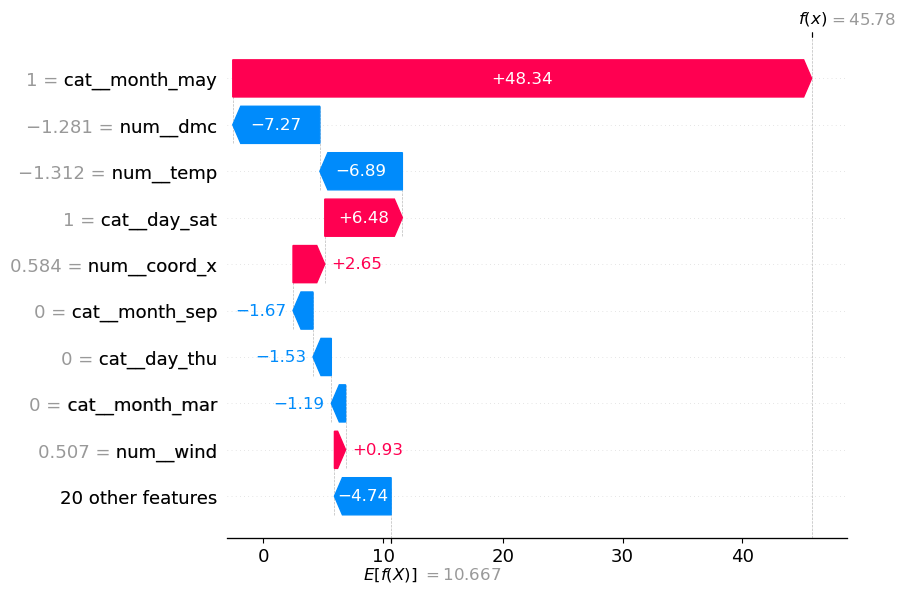

In [79]:
# Get transformed test data
X_trans = grid_a.best_estimator_.named_steps['preprocessing'].transform(X_test)
model = grid_a.best_estimator_.named_steps['regressor']
feature_names = grid_a.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

# Create SHAP explainer for linear model
explainer = shap.KernelExplainer(model.predict, X_trans[:100])

# SHAP values for one observation
shap_values = explainer.shap_values(X_trans[0:1])

# Manual SHAP plot using legacy-safe structure
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_trans[0],
        feature_names=feature_names
    )
)

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


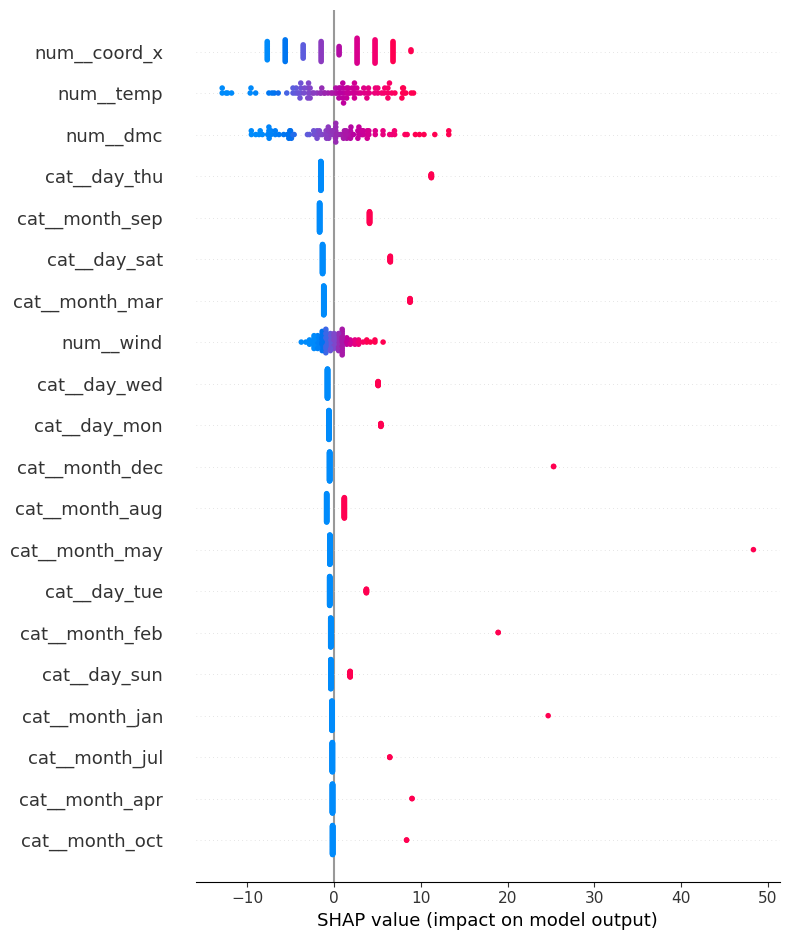

In [80]:
# Get SHAP values for a batch
shap_values_all = explainer.shap_values(X_trans[:100])
feature_names = grid_a.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

# Use SHAP's summary_plot with color bar disabled to avoid error
plt.figure()
shap.summary_plot(
    shap_values_all,
    features=X_trans[:100],
    feature_names=feature_names,
    color_bar=False
)

# Explain

## Which features are most important for a specific observation?

In the SHAP waterfall plot, the model's prediction was driven heavily by `cat__month_may`, which increased the prediction by over 48 units. Meanwhile, features like `num__dmc` and `num__temp` reduced the prediction, showing their influence in specific cases. This gives a clear view of **which features drove the model’s decision** for one specific input.

## Which features are most/least important overall?

From the SHAP beeswarm plot, we can see that the **most impactful features** across the dataset are:
- `num__coord_x`
- `num__temp`
- `num__dmc`

These features frequently push the model's predictions up or down. Meanwhile, features such as:
- `cat__month_jan`
- `cat__month_apr`
- `cat__month_oct`

have very little impact and could be considered **low-value** in the model.

## If you were to remove features, which ones and why?

Based on their consistently low SHAP impact, features like `cat__month_jan`, `cat__month_oct`, and `cat__month_apr` could be dropped. To validate:
1. Retrain the model without these features.
2. Re-evaluate performance using cross-validation (e.g., neg MSE).
3. Compare the results — if the score stays similar or improves, it confirms those features add little value.


## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [X] Created a branch with the correct naming convention.
- [X] Ensured that the repository is public.
- [X] Reviewed the PR description guidelines and adhered to them.
- [X] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.